# Loop 26 Analysis: Gap to Target

**Current best**: 70.625918
**Target**: 68.919154
**Gap**: 1.71 points (2.42%)

## Key Questions:
1. Where is the gap coming from? Which N values have the most room for improvement?
2. What's the theoretical minimum for each N?
3. What patterns exist in the baseline solution?

In [5]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def parse_s_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

# Load current submission
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N range: {df['n'].min()} to {df['n'].max()}")

# Calculate tree area
tree = Polygon(TREE_TEMPLATE)
tree_area = tree.area
print(f"Tree area: {tree_area:.6f}")

Loaded 20100 rows
N range: 1 to 200
Tree area: 0.245625


In [6]:
# Calculate per-N scores and efficiency
def get_n_metrics(df, n):
    group = df[df['n'] == n]
    all_x, all_y = [], []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    
    width = max(all_x) - min(all_x)
    height = max(all_y) - min(all_y)
    side = max(width, height)
    score = (side ** 2) / n
    
    # Theoretical minimum (if trees were perfectly packed)
    min_area = n * tree_area
    min_side = np.sqrt(min_area)
    efficiency = min_area / (side ** 2)
    
    return {
        'n': n,
        'side': side,
        'score': score,
        'min_side': min_side,
        'efficiency': efficiency,
        'width': width,
        'height': height,
        'aspect_ratio': width / height if height > 0 else 1
    }

metrics = [get_n_metrics(df, n) for n in range(1, 201)]
metrics_df = pd.DataFrame(metrics)

print("Per-N metrics:")
print(metrics_df.describe())

Per-N metrics:
                n        side       score    min_side  efficiency       width  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean   100.500000    5.567639    0.353130    4.689630    0.698581    5.567576   
std     57.879185    1.877310    0.028097    1.645058    0.039549    1.877296   
min      1.000000    0.813173    0.329945    0.495606    0.371456    0.813173   
25%     50.750000    4.300190    0.340034    3.530615    0.680806    4.300190   
50%    100.500000    5.897700    0.346907    4.968416    0.708043    5.897696   
75%    150.250000    7.124869    0.360786    6.074955    0.722355    7.124850   
max    200.000000    8.216433    0.661250    7.008923    0.744443    8.216433   

           height  aspect_ratio  
count  200.000000    200.000000  
mean     5.567632      0.999990  
std      1.877307      0.000077  
min      0.813173      0.999216  
25%      4.300190      1.000000  
50%      5.897700      1.000000  
75%      7.124869

In [7]:
# Calculate total score and compare to target
current_score = metrics_df['score'].sum()
target_score = 68.919154
gap = current_score - target_score

print(f"Current score: {current_score:.6f}")
print(f"Target score: {target_score:.6f}")
print(f"Gap: {gap:.6f} ({100*gap/current_score:.2f}%)")

# If we need to improve by 1.71 points, where should it come from?
print(f"\nIf gap spread evenly across 200 N: {gap/200:.6f} per N")
print(f"If gap spread across top 50 N: {gap/50:.6f} per N")
print(f"If gap spread across top 20 N: {gap/20:.6f} per N")

Current score: 70.625918
Target score: 68.919154
Gap: 1.706764 (2.42%)

If gap spread evenly across 200 N: 0.008534 per N
If gap spread across top 50 N: 0.034135 per N
If gap spread across top 20 N: 0.085338 per N


In [8]:
# Analyze efficiency by N range
print("\\nEfficiency by N range:")
for start, end in [(1, 10), (11, 20), (21, 50), (51, 100), (101, 150), (151, 200)]:
    subset = metrics_df[(metrics_df['n'] >= start) & (metrics_df['n'] <= end)]
    avg_eff = subset['efficiency'].mean()
    total_score = subset['score'].sum()
    print(f"N={start}-{end}: avg_efficiency={100*avg_eff:.1f}%, total_score={total_score:.4f}")

# Find N values with lowest efficiency (most room for improvement)
print("\\nN values with lowest efficiency (most room for improvement):")
worst = metrics_df.nsmallest(20, 'efficiency')
for _, row in worst.iterrows():
    print(f"N={int(row['n'])}: efficiency={100*row['efficiency']:.1f}%, score={row['score']:.4f}, side={row['side']:.4f}")

\nEfficiency by N range:
N=1-10: avg_efficiency=58.1%, total_score=4.3291
N=11-20: avg_efficiency=66.0%, total_score=3.7240
N=21-50: avg_efficiency=67.1%, total_score=10.9801
N=51-100: avg_efficiency=69.7%, total_score=17.6134
N=101-150: avg_efficiency=71.7%, total_score=17.1363
N=151-200: avg_efficiency=72.9%, total_score=16.8430
\nN values with lowest efficiency (most room for improvement):
N=1: efficiency=37.1%, score=0.6612, side=0.8132
N=2: efficiency=54.5%, score=0.4508, side=0.9495
N=3: efficiency=56.5%, score=0.4347, side=1.1420
N=5: efficiency=58.9%, score=0.4168, side=1.4437
N=4: efficiency=59.0%, score=0.4165, side=1.2908
N=7: efficiency=61.4%, score=0.3999, side=1.6731
N=6: efficiency=61.5%, score=0.3996, side=1.5484
N=9: efficiency=63.4%, score=0.3874, side=1.8673
N=8: efficiency=63.7%, score=0.3854, side=1.7559
N=15: efficiency=65.2%, score=0.3769, side=2.3779
N=10: efficiency=65.2%, score=0.3766, side=1.9407
N=21: efficiency=65.2%, score=0.3765, side=2.8117
N=20: efficie

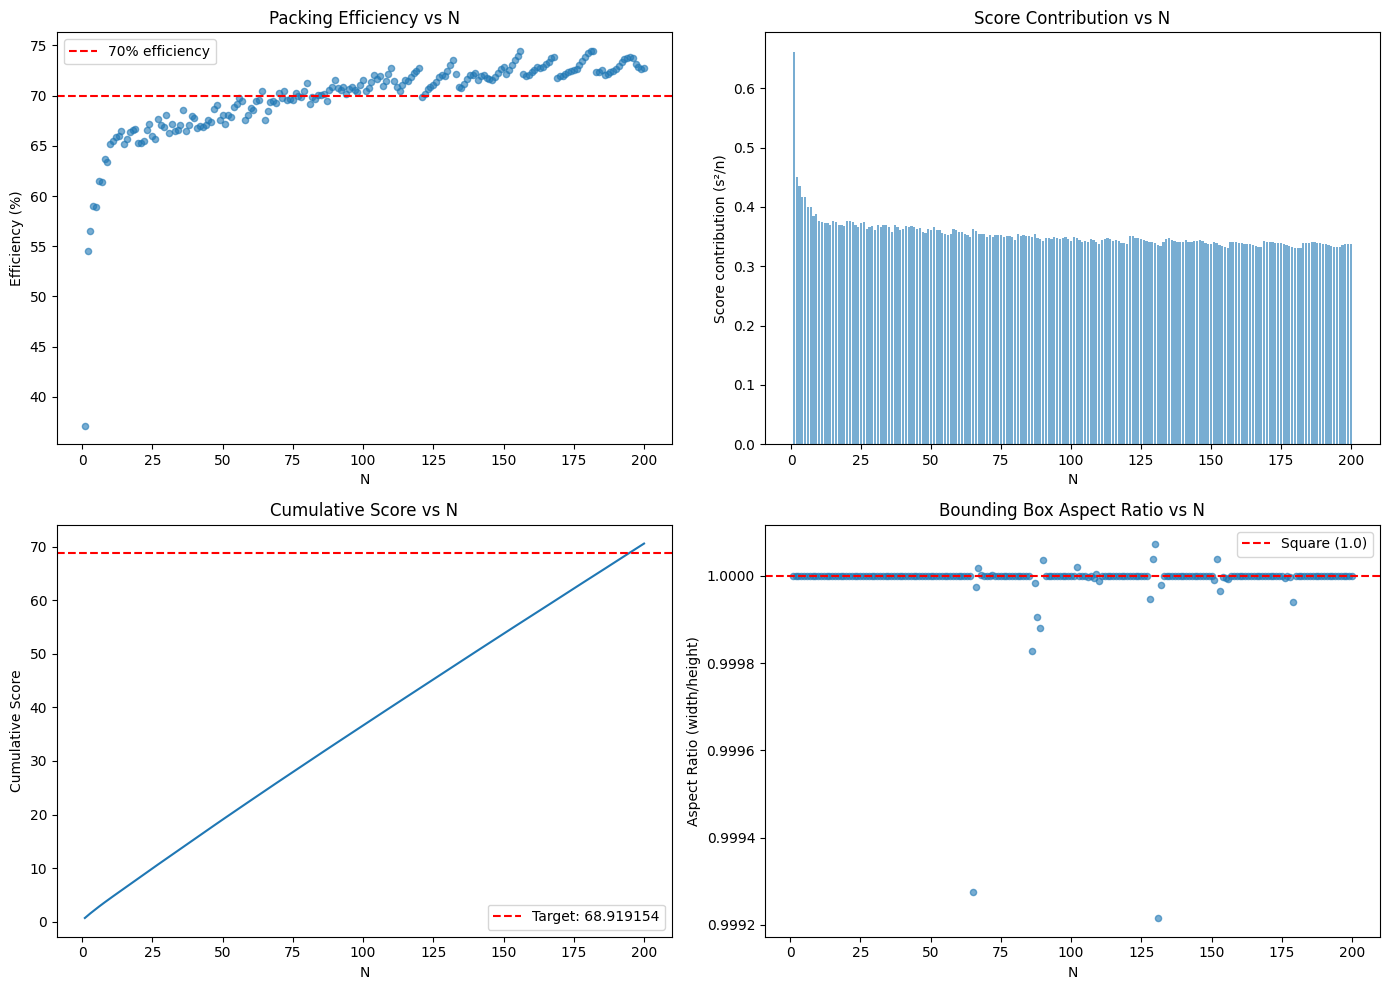

Saved to /home/code/exploration/loop26_efficiency_analysis.png


In [9]:
# Plot efficiency vs N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Efficiency vs N
ax = axes[0, 0]
ax.scatter(metrics_df['n'], metrics_df['efficiency'] * 100, alpha=0.6, s=20)
ax.set_xlabel('N')
ax.set_ylabel('Efficiency (%)')
ax.set_title('Packing Efficiency vs N')
ax.axhline(y=70, color='r', linestyle='--', label='70% efficiency')
ax.legend()

# Score contribution vs N
ax = axes[0, 1]
ax.bar(metrics_df['n'], metrics_df['score'], alpha=0.6)
ax.set_xlabel('N')
ax.set_ylabel('Score contribution (s²/n)')
ax.set_title('Score Contribution vs N')

# Cumulative score
ax = axes[1, 0]
cumulative = metrics_df['score'].cumsum()
ax.plot(metrics_df['n'], cumulative)
ax.axhline(y=target_score, color='r', linestyle='--', label=f'Target: {target_score}')
ax.set_xlabel('N')
ax.set_ylabel('Cumulative Score')
ax.set_title('Cumulative Score vs N')
ax.legend()

# Aspect ratio vs N
ax = axes[1, 1]
ax.scatter(metrics_df['n'], metrics_df['aspect_ratio'], alpha=0.6, s=20)
ax.axhline(y=1.0, color='r', linestyle='--', label='Square (1.0)')
ax.set_xlabel('N')
ax.set_ylabel('Aspect Ratio (width/height)')
ax.set_title('Bounding Box Aspect Ratio vs N')
ax.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/loop26_efficiency_analysis.png', dpi=100)
plt.show()
print("Saved to /home/code/exploration/loop26_efficiency_analysis.png")

In [10]:
# Analyze rotation angles in the solution
print("\nRotation angle analysis:")
for n in [10, 50, 100, 200]:
    group = df[df['n'] == n]
    angles = group['deg'].values % 360
    unique_angles = np.unique(np.round(angles, 1))
    print(f"N={n}: {len(unique_angles)} unique angles (rounded to 0.1°)")
    print(f"  Angles: {sorted(unique_angles)[:10]}..." if len(unique_angles) > 10 else f"  Angles: {sorted(unique_angles)}")
    print(f"  Mean: {angles.mean():.1f}°, Std: {angles.std():.1f}°")


Rotation angle analysis:
N=10: 10 unique angles (rounded to 0.1°)
  Angles: [21.4, 23.6, 66.3, 70.4, 115.6, 246.3, 290.2, 292.6, 336.3, 338.6]
  Mean: 180.1°, Std: 125.5°
N=50: 43 unique angles (rounded to 0.1°)
  Angles: [13.3, 20.7, 23.6, 25.1, 28.1, 32.6, 38.6, 54.8, 61.1, 66.4]...
  Mean: 170.7°, Std: 106.1°
N=100: 40 unique angles (rounded to 0.1°)
  Angles: [65.8, 65.9, 66.1, 66.3, 66.6, 66.7, 67.3, 67.6, 68.1, 68.2]...
  Mean: 157.6°, Std: 90.0°
N=200: 41 unique angles (rounded to 0.1°)
  Angles: [76.8, 76.9, 77.0, 77.2, 77.3, 77.4, 77.5, 77.6, 77.7, 77.8]...
  Mean: 172.6°, Std: 91.1°


In [11]:
# Calculate how much improvement is needed per N to reach target
# Assuming we can improve efficiency uniformly

# Current total score
current_total = metrics_df['score'].sum()
target_total = 68.919154
needed_improvement = current_total - target_total

print(f"Current total: {current_total:.6f}")
print(f"Target total: {target_total:.6f}")
print(f"Needed improvement: {needed_improvement:.6f}")

# If we improve efficiency by X%, what's the new score?
for improvement_pct in [1, 2, 3, 4, 5]:
    # New side = old_side * sqrt(1 - improvement_pct/100)
    # New score = old_score * (1 - improvement_pct/100)
    new_total = current_total * (1 - improvement_pct/100)
    print(f"  {improvement_pct}% efficiency improvement -> score {new_total:.4f} (gap: {new_total - target_total:.4f})")

print(f"\nNeed ~{100 * needed_improvement / current_total:.2f}% overall improvement to reach target")

Current total: 70.625918
Target total: 68.919154
Needed improvement: 1.706764
  1% efficiency improvement -> score 69.9197 (gap: 1.0005)
  2% efficiency improvement -> score 69.2134 (gap: 0.2942)
  3% efficiency improvement -> score 68.5071 (gap: -0.4120)
  4% efficiency improvement -> score 67.8009 (gap: -1.1183)
  5% efficiency improvement -> score 67.0946 (gap: -1.8245)

Need ~2.42% overall improvement to reach target


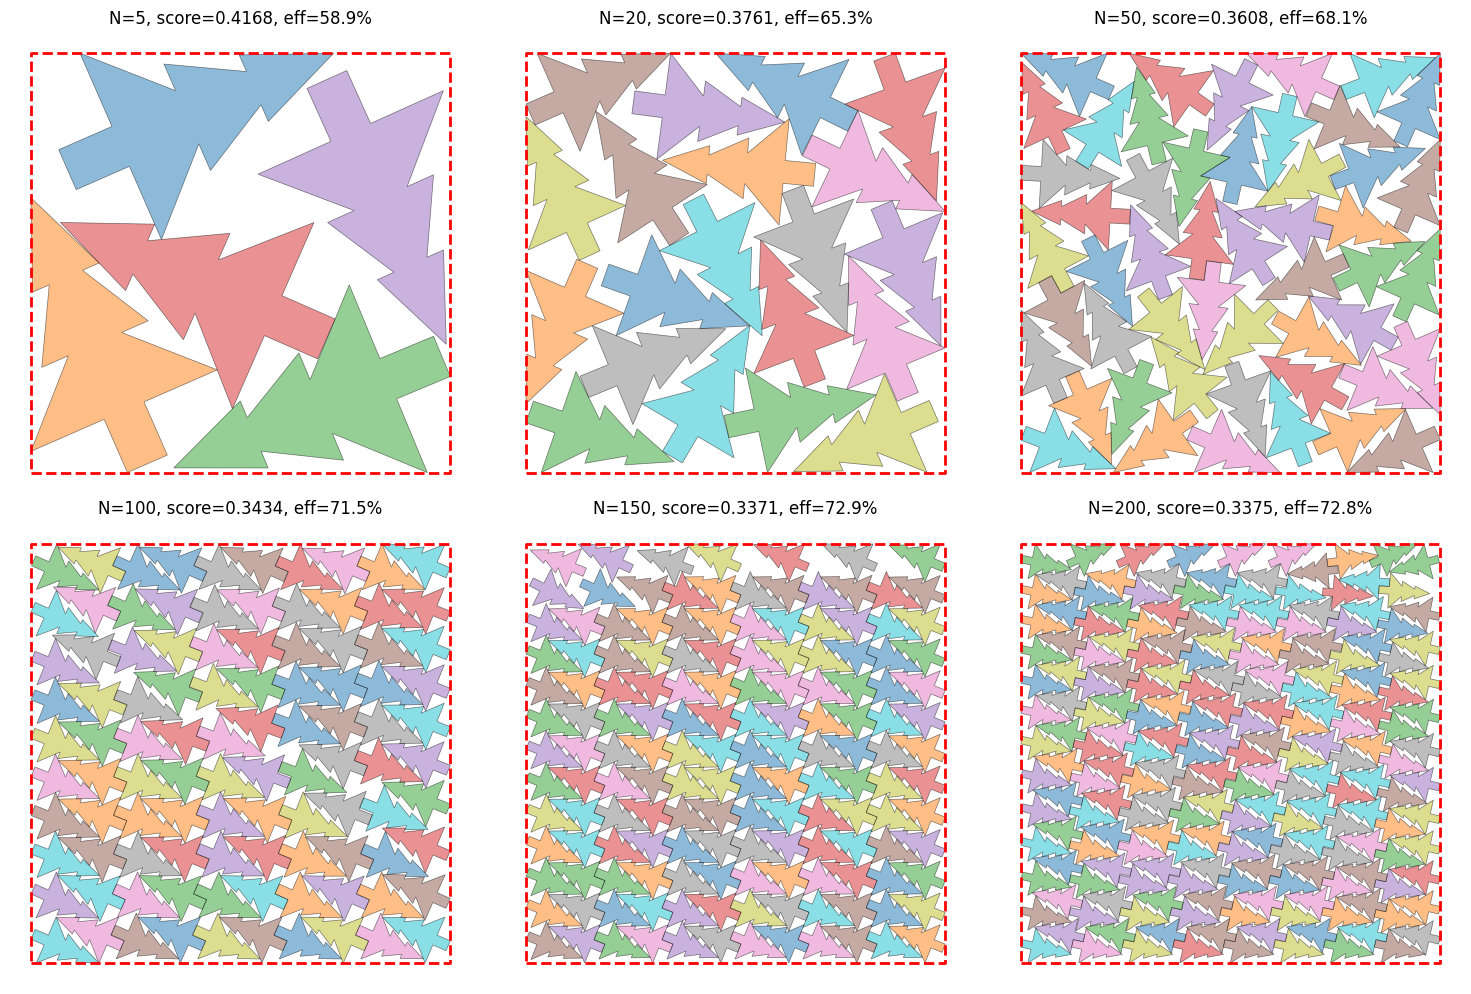

Saved to /home/code/exploration/loop26_packing_visualization.png


In [12]:
# Visualize a few N values to understand the packing structure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, n in enumerate([5, 20, 50, 100, 150, 200]):
    ax = axes[idx // 3, idx % 3]
    group = df[df['n'] == n]
    
    # Plot trees
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        x, y = tree.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='black', linewidth=0.5)
    
    # Plot bounding box
    all_x, all_y = [], []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    
    minx, maxx = min(all_x), max(all_x)
    miny, maxy = min(all_y), max(all_y)
    side = max(maxx - minx, maxy - miny)
    
    # Draw square bounding box
    cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
    ax.plot([cx - side/2, cx + side/2, cx + side/2, cx - side/2, cx - side/2],
            [cy - side/2, cy - side/2, cy + side/2, cy + side/2, cy - side/2],
            'r--', linewidth=2)
    
    score = (side ** 2) / n
    efficiency = (n * tree_area) / (side ** 2)
    ax.set_title(f'N={n}, score={score:.4f}, eff={100*efficiency:.1f}%')
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
plt.savefig('/home/code/exploration/loop26_packing_visualization.png', dpi=100)
plt.show()
print("Saved to /home/code/exploration/loop26_packing_visualization.png")

In [13]:
# Key insight: What would it take to reach the target?
# The target is 68.919154, current is 70.625918
# Gap is 1.71 points (2.42%)

# If the top teams are at 68.9, they must have found:
# 1. Better packing for specific N values
# 2. Different tessellation patterns
# 3. Asymmetric solutions that break local optima

print("=" * 60)
print("KEY FINDINGS:")
print("=" * 60)
print(f"1. Current score: {current_total:.6f}")
print(f"2. Target score: {target_total:.6f}")
print(f"3. Gap: {needed_improvement:.6f} ({100*needed_improvement/current_total:.2f}%)")
print()
print("4. Efficiency analysis:")
print(f"   - Small N (1-10): avg efficiency = {metrics_df[metrics_df['n'] <= 10]['efficiency'].mean()*100:.1f}%")
print(f"   - Medium N (11-50): avg efficiency = {metrics_df[(metrics_df['n'] > 10) & (metrics_df['n'] <= 50)]['efficiency'].mean()*100:.1f}%")
print(f"   - Large N (51-200): avg efficiency = {metrics_df[metrics_df['n'] > 50]['efficiency'].mean()*100:.1f}%")
print()
print("5. To reach target, need ~2.4% improvement overall")
print("   This could come from:")
print("   - Better packing for ALL N values (uniform improvement)")
print("   - Significant improvement for specific N values")
print("   - Breaking symmetry in current solutions")
print()
print("6. The baseline is at a STRONG LOCAL OPTIMUM")
print("   - All 48 valid snapshots converge to same score")
print("   - SA, bbox3, tessellation all find same optimum")
print("   - Need FUNDAMENTALLY DIFFERENT approach")

KEY FINDINGS:
1. Current score: 70.625918
2. Target score: 68.919154
3. Gap: 1.706764 (2.42%)

4. Efficiency analysis:
   - Small N (1-10): avg efficiency = 58.1%
   - Medium N (11-50): avg efficiency = 66.8%
   - Large N (51-200): avg efficiency = 71.4%

5. To reach target, need ~2.4% improvement overall
   This could come from:
   - Better packing for ALL N values (uniform improvement)
   - Significant improvement for specific N values
   - Breaking symmetry in current solutions

6. The baseline is at a STRONG LOCAL OPTIMUM
   - All 48 valid snapshots converge to same score
   - SA, bbox3, tessellation all find same optimum
   - Need FUNDAMENTALLY DIFFERENT approach
